# Bird Spectrogram Data Preprocessing

This notebook preprocesses the bird spectrogram dataset for deep learning. We inspect the raw HDF5 file, stack and label the spectrograms, split into train/validation/test sets, and save the processed splits.


## 1. Imports

We import all necessary libraries for data handling and splitting.


In [40]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
import os
from collections import Counter


## 2. Inspect HDF5 File Structure

We check the available datasets and their shapes in the HDF5 file to understand the data organization.



In [41]:
hdf5_path = '../data/bird_spectrograms.hdf5' 
with h5py.File(hdf5_path, 'r') as f:
    print("Datasets:", list(f.keys()))
    for key in f.keys():
        print(f"{key} shape: {f[key].shape}")


Datasets: ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']
amecro shape: (128, 517, 66)
amerob shape: (128, 517, 172)
bewwre shape: (128, 517, 144)
bkcchi shape: (128, 517, 45)
daejun shape: (128, 517, 125)
houfin shape: (128, 517, 84)
houspa shape: (128, 517, 630)
norfli shape: (128, 517, 37)
rewbla shape: (128, 517, 187)
sonspa shape: (128, 517, 263)
spotow shape: (128, 517, 137)
whcspa shape: (128, 517, 91)


## 3. Stack Spectrograms and Assign Labels

We load each species' spectrograms, transpose to put the sample axis first, and stack them into a single array. We also create the corresponding label array.


In [42]:
species_list = ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 
                'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']

all_spectrograms = []
all_labels = []

with h5py.File('../data/bird_spectrograms.hdf5', 'r') as f:
    for species_idx, species_name in enumerate(species_list):
        spectrogram_data = f[species_name][:]
        spectrogram_data = np.transpose(spectrogram_data, (2, 0, 1))
        all_spectrograms.append(spectrogram_data)
        all_labels.extend([species_idx] * spectrogram_data.shape[0])

X = np.concatenate(all_spectrograms, axis=0)
y = np.array(all_labels)

print(f"Combined spectrogram shape: {X.shape}")
print("Label distribution:")
import collections
label_dist = collections.Counter(y)
print(dict(zip(species_list, [label_dist[i] for i in range(len(species_list))])))


Combined spectrogram shape: (1981, 128, 517)
Label distribution:
{'amecro': 66, 'amerob': 172, 'bewwre': 144, 'bkcchi': 45, 'daejun': 125, 'houfin': 84, 'houspa': 630, 'norfli': 37, 'rewbla': 187, 'sonspa': 263, 'spotow': 137, 'whcspa': 91}


## 4. Explore and Visualize the Dataset

This cell displays the number of samples per species, visualizes a few sample spectrograms, and encodes the labels for machine learning.


Samples per species:
amecro: 66
amerob: 172
bewwre: 144
bkcchi: 45
daejun: 125
houfin: 84
houspa: 630
norfli: 37
rewbla: 187
sonspa: 263
spotow: 137
whcspa: 91


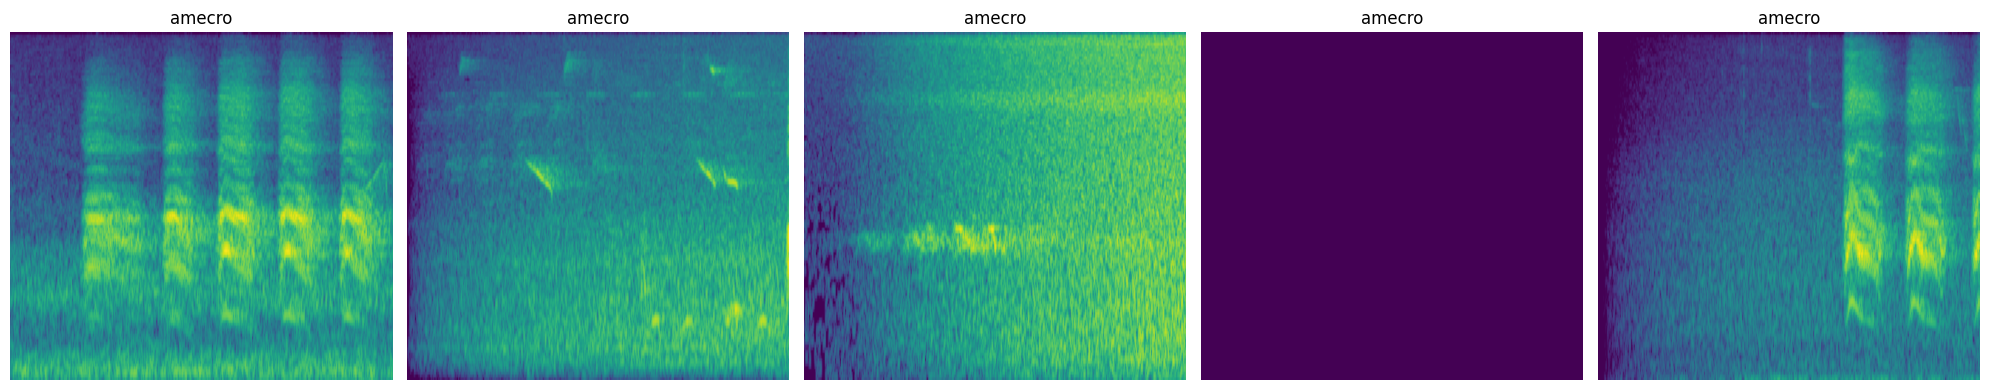

Encoded species labels: {'amecro': 0, 'amerob': 1, 'bewwre': 2, 'bkcchi': 3, 'daejun': 4, 'houfin': 5, 'houspa': 6, 'norfli': 7, 'rewbla': 8, 'sonspa': 9, 'spotow': 10, 'whcspa': 11}


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import OneHotEncoder

# 1. Number of samples per species
samples_per_species = {species: Counter(y)[i] for i, species in enumerate(species_list)}
print("Samples per species:")
for species, count in samples_per_species.items():
    print(f"{species}: {count}")

# 2. Visualize a few spectrograms
n_show = 5
fig, axs = plt.subplots(1, n_show, figsize=(20, 4))
for i in range(n_show):
    axs[i].imshow(X[i, :, :], aspect='auto', origin='lower')
    axs[i].set_title(f"{species_list[y[i]]}")
    axs[i].axis('off')
plt.tight_layout()
plt.show()

# 3. One-hot encode the labels (for reference, not used in splitting)
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# 4. Print species-to-integer mapping
encoded_labels = {species: idx for idx, species in enumerate(species_list)}
print("Encoded species labels:", encoded_labels)


## 5. Add Channel Dimension for CNNs

We add a channel dimension to the spectrograms to make them compatible with convolutional neural networks.


In [43]:
X_ml = X[..., np.newaxis]

print(f"Data shape: {X_ml.shape}")
print(f"Label shape: {y.shape}")

Data shape: (1981, 128, 517, 1)
Label shape: (1981,)


## 6. Split Data into Training, Validation, and Test Sets

We split the data into training, validation, and test sets using stratified sampling to maintain class balance in each split.


In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X_ml, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

print(f"Final training data shape: {X_train_final.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}\n")

print("Final train label distribution:")
print({species: Counter(y_train_final)[i] for i, species in enumerate(species_list)})
print("\nValidation label distribution:")
print({species: Counter(y_val)[i] for i, species in enumerate(species_list)})
print("\nTest label distribution:")
print({species: Counter(y_test)[i] for i, species in enumerate(species_list)})


Final training data shape: (1267, 128, 517, 1)
Validation data shape: (317, 128, 517, 1)
Test data shape: (397, 128, 517, 1)

Final train label distribution:
{'amecro': 42, 'amerob': 110, 'bewwre': 92, 'bkcchi': 29, 'daejun': 80, 'houfin': 54, 'houspa': 403, 'norfli': 24, 'rewbla': 119, 'sonspa': 168, 'spotow': 88, 'whcspa': 58}

Validation label distribution:
{'amecro': 11, 'amerob': 27, 'bewwre': 23, 'bkcchi': 7, 'daejun': 20, 'houfin': 13, 'houspa': 101, 'norfli': 6, 'rewbla': 30, 'sonspa': 42, 'spotow': 22, 'whcspa': 15}

Test label distribution:
{'amecro': 13, 'amerob': 35, 'bewwre': 29, 'bkcchi': 9, 'daejun': 25, 'houfin': 17, 'houspa': 126, 'norfli': 7, 'rewbla': 38, 'sonspa': 53, 'spotow': 27, 'whcspa': 18}


## 7. Save Processed Splits

We save the processed training, validation, and test splits, along with the species list, to a new HDF5 file for easy loading during modeling.


In [45]:
with h5py.File('../data/processed_bird_splits.hdf5', 'w') as f:
    f.create_dataset('X_train', data=X_train_final)
    f.create_dataset('y_train', data=y_train_final)
    f.create_dataset('X_val', data=X_val)
    f.create_dataset('y_val', data=y_val)
    f.create_dataset('X_test', data=X_test)
    f.create_dataset('y_test', data=y_test)
    f.attrs['species'] = np.array(species_list, dtype='S')  # Save species names as bytes

print("Processed splits saved to ../data/processed_bird_splits.hdf5")


Processed splits saved to ../data/processed_bird_splits.hdf5
